## Individual solution for boosting

#### Imports

In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble.partial_dependence import plot_partial_dependence
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import textwrap # for wrapping answer descriptions
from individual_soln import * # use functions from individual_soln.py

#### 2) Load and train-test-split data

In [2]:
(X_train, X_test, y_train, y_test), column_names = load_and_split_data()

#### 3) Define models

In [3]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=1)

gdbr = GradientBoostingRegressor(learning_rate=0.1, loss='ls',
                                 n_estimators=100, random_state=1)

abr = AdaBoostRegressor(DecisionTreeRegressor(), learning_rate=0.1,
                                 loss='linear', n_estimators=100, random_state=1)

#### 4) Perform the cross validation and display results

In [4]:
k = 10 # number of folds in the cross-validation 
cross_val(rf, X_train, y_train, k) 
cross_val(gdbr, X_train, y_train, k) 
cross_val(abr, X_train, y_train, k); 

RandomForestRegressor     Train CV | MSE: 9.865 | R2: 0.867
GradientBoostingRegressor Train CV | MSE: 8.533 | R2: 0.885
AdaBoostRegressor         Train CV | MSE: 9.663 | R2: 0.870


In [5]:
answer_description(4) 

4) There isn't a 'best' model at this point because the best hyperparameters
for each model haven't been determined.  For example, AdaBoostRegressor
may be the best model for this data but with its present hyperparameters it
performs second best.


#### 5) Try a gradient boosting regressor with learning rate = 1.0

In [6]:
gdbr_lr1 = GradientBoostingRegressor(learning_rate=1.0, loss='ls',
                                     n_estimators=100, random_state=1) 
print "Cross validation score of Gradient Boosting Regressor with lr = 0.1:"
cross_val(gdbr, X_train, y_train, k) 
print "Cross validation score of Gradient Boosting Regressor with lr = 1.0:"
cross_val(gdbr_lr1, X_train, y_train, k);

Cross validation score of Gradient Boosting Regressor with lr = 0.1:
GradientBoostingRegressor Train CV | MSE: 8.533 | R2: 0.885
Cross validation score of Gradient Boosting Regressor with lr = 1.0:
GradientBoostingRegressor Train CV | MSE: 21.149 | R2: 0.725


In [7]:
answer_description(5) 

5) The MSE has more than doubled with learning rate = 1.


#### 6) Investigate effect of the number of iterations

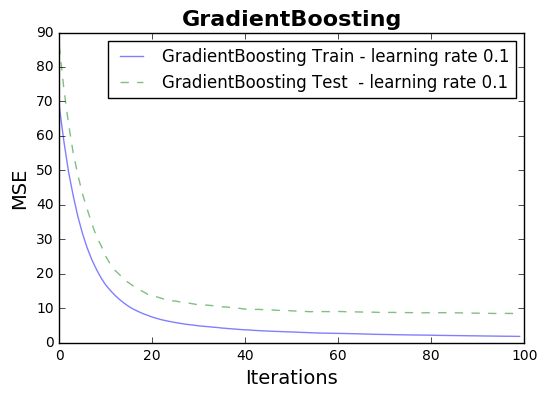

In [8]:
stage_score_plot(gdbr, X_train, y_train, X_test, y_test)
plt.legend();

#### 7) Investigate effect of learning rate

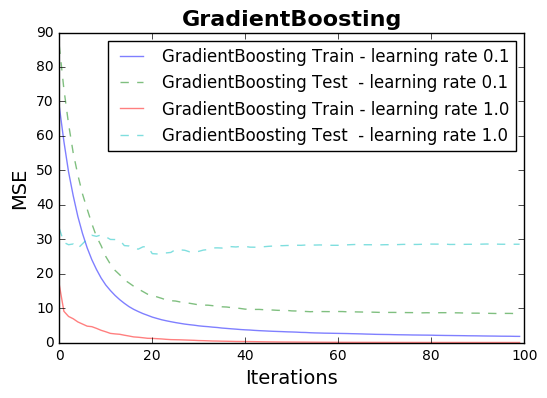

In [9]:
stage_score_plot(gdbr, X_train, y_train, X_test, y_test)
stage_score_plot(gdbr_lr1, X_train, y_train, X_test, y_test)
plt.legend();

#### 8) Explain the plot behavior

In [10]:
answer_description(8)

8) For both learning rates the train error drops to near zero with
progressive boosting stages (iterations).  However, the larger learning
rate test error doesn't decrease as more iterations are added.  The larger
learning rate makes large changes per iteration and so likely overfits
the data.  For the lower learning rate model to get low test error, many
boosting stages are required.


#### 9) Compare the Gradient Boosting Regressor with lr = 0.1 to a Random Forest Regressor

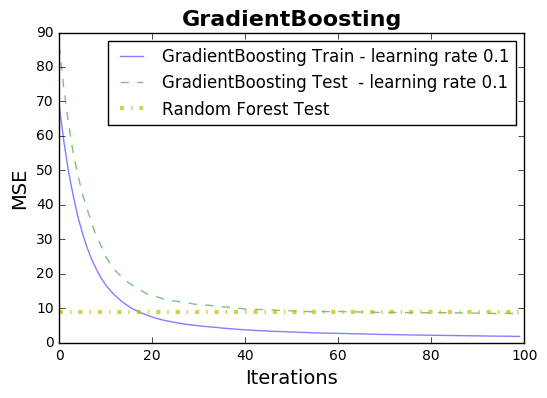

In [11]:
stage_score_plot(gdbr, X_train, y_train, X_test, y_test)
rf_score_plot(rf, X_train, y_train, X_test, y_test)
plt.legend();

In [12]:
answer_description(9)

9) Gradient Boost outperforms Random Forest at about 60 iterations.


#### 10) Compare Adaboost Regressor with lr = 0.1 to the Random Forest Regressor

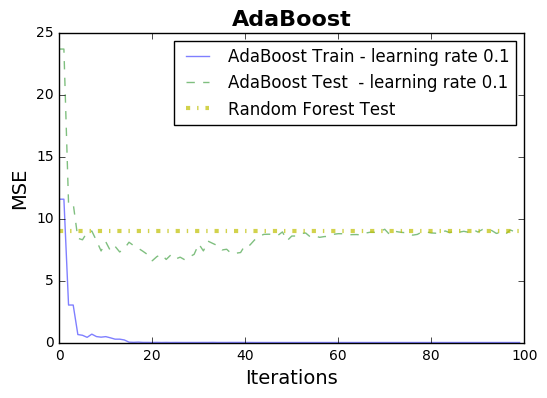

In [13]:
stage_score_plot(abr, X_train, y_train, X_test, y_test)
rf_score_plot(rf, X_train, y_train, X_test, y_test)
plt.legend();

In [14]:
answer_description(10)

10) With the current hyperparameters, Adaboost performs erratically.
With very few iterations it outperforms Random Forest but then its
MSE rises to perform worse than the Random Forest.


#### 11) Use gridsearch to find the best hyperparameters for the Random Forest

In [15]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [10, 20, 40, 80],
                      'random_state': [1]}
rf_best_params, rf_best_model = gridsearch_with_output(RandomForestRegressor(), 
                                                       random_forest_grid, 
                                                       X_train, y_train)
print "\nComparing model with gridsearch params to initial model on Test set."
rf.fit(X_train, y_train)
display_default_and_gsearch_model_results(rf, rf_best_model, X_test, y_test)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   29.8s
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  1.2min finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
bootstrap            | True     | [True, False]
min_samples_leaf     | 1        | [1, 2, 4]
n_estimators         | 40       | [10, 20, 40, 80]
min_samples_split    | 2        | [2, 4]
random_state         | 1        | [1]
max_features         | None     | ['sqrt', 'log2', None]
max_depth            | None     | [3, None]

Comparing model with gridsearch params to initial model on Test set.
Results for RandomForest
Gridsearched model mse: 8.817 | r2: 0.911
     Default model mse: 8.972 | r2: 0.909


#### 12) Use gridsearch to find the best hyperparameters for the Gradient Boosting

In [16]:
gradient_boosting_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
                          'max_depth': [2, 4, 6],
                          'min_samples_leaf': [1, 2, 5, 10],
                          'max_features': [1.0, 0.3, 0.1],
                          'n_estimators': [500],
                          'random_state': [1]}
gdbr_best_params, gdbr_best_model = gridsearch_with_output(GradientBoostingRegressor(), 
                                                           gradient_boosting_grid, 
                                                           X_train, y_train)
print "\nComparing model with gridsearch params to initial model on Test set."
gdbr.fit(X_train, y_train)
display_default_and_gsearch_model_results(gdbr, gdbr_best_model, X_test, y_test)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:   25.0s finished



Result of gridsearch:
Parameter            | Optimal  | Gridsearch values
-------------------------------------------------------
learning_rate        | 0.05     | [0.1, 0.05, 0.02, 0.01]
min_samples_leaf     | 1        | [1, 2, 5, 10]
n_estimators         | 500      | [500]
random_state         | 1        | [1]
max_features         | 1.0      | [1.0, 0.3, 0.1]
max_depth            | 4        | [2, 4, 6]

Comparing model with gridsearch params to initial model on Test set.
Results for GradientBoosting
Gridsearched model mse: 8.393 | r2: 0.915
     Default model mse: 8.395 | r2: 0.915


In [17]:
answer_description(12)

11 & 12) For both RandomForest and GradientBoosting regressors, the model
with gridsearched parameters outperformed (had a lower mse) than the 
default model.
